## Isolation Forest

The goal of this notebook is to apply the Isolation Forest anomaly detection technique to the property data.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, make_scorer
from sklearn import preprocessing

#### Load Data

In [2]:
# Read in the data
df = pd.read_hdf('../data/processed/bexar_processed.h5')

# Fill na values in with 1 in crim_prop with 0 so they don't get dropped later on
df.loc[df.crim_prop==1,'price_psf'] = df.loc[df.crim_prop==1,'price_psf'].fillna(0)

trim_prop_df = df[(df.price_psf<df.price_psf.quantile(.999)) | (df.price_psf.isna())]

In [3]:
# Grab all columns that are under the 70,000 nan limit
nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop([
    'prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
    'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
    'bexar_2017_market_value','bexar_2018_market_value','owner_zip_code',
    'property_zip','neighborhood_code'
])

sub_df = trim_prop_df[variables_list]
df_if = sub_df.dropna()
print("Number of properties after trimming:", len(df_if))

Number of properties after trimming: 530923


In [4]:
# Get criminal property rate
crim_prop_rate = 1 - (len(df_if[df_if['crim_prop']==0]) / len(df_if))
print("Rate is: {:.5%}".format(crim_prop_rate))

Rate is: 0.00885%


In [5]:
# dfSA['binary_target'] = [1 if x==b'normal.' else -1 for x in dfSA[target]]
df_if['binary_y'] = [1 if x==0 else -1 for x in df_if.crim_prop]

/Users/matthewpokorny/anaconda3/envs/property_project_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
df_if.binary_y.value_counts()

 1    530876
-1        47
Name: binary_y, dtype: int64

In [9]:
# Normalize
X = df_if.iloc[:,:-2]
X_norm = preprocessing.normalize(X)

y = df_if.binary_y

# Split the data into train and test
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(
    X_norm, y, test_size=0.33, random_state=42
)

In [10]:
clf = IsolationForest(
    max_samples=0.2,
    n_estimators=100,
    contamination=0.01,
    random_state=42
)

In [11]:
%%time
# Fit the model
clf.fit(X_train_norm,y_train_norm)
# Predict
y_pred_train = clf.predict(X_train_norm)

CPU times: user 34.5 s, sys: 5.05 s, total: 39.6 s
Wall time: 40.1 s


In [15]:
print(classification_report(
    y_train_norm,
    y_pred_train,
    zero_division=0,
    digits=4,
    target_names=['criminally-linked', 'normal']
))

                   precision    recall  f1-score   support

criminally-linked     0.0017    0.2000    0.0033        30
           normal     0.9999    0.9900    0.9949    355688

         accuracy                         0.9899    355718
        macro avg     0.5008    0.5950    0.4991    355718
     weighted avg     0.9998    0.9899    0.9949    355718



In [13]:
print(recall_score(
    y_train_norm,
    y_pred_train,
    zero_division=0
))

0.9900137198893412


In [118]:
def plot_confusion_matrix(conf_matrix, title, classes=['criminally-linke', 'normal'],
                          cmap=plt.cm.Oranges, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8,8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=11)
    plt.yticks(tick_marks, classes, rotation=45, fontsize=11)

    fmt = '.1%'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="top",
                 fontsize=16,
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=14, rotation=0)
    plt.xlabel('Predicted label',fontsize=14)
    
    if save:
        plt.savefig(saveas, dpi=100)

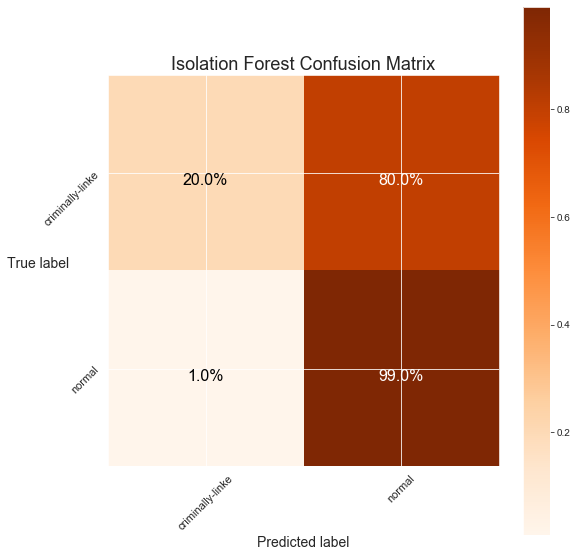

In [119]:
conf_matrix = confusion_matrix(y_train_norm, y_pred_train)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix',save=False)

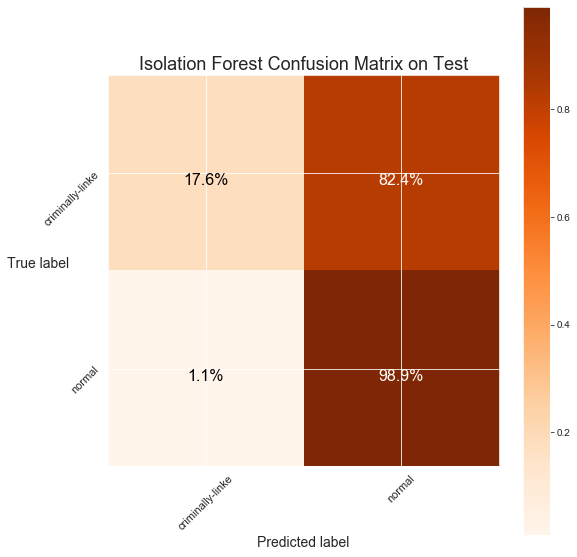

In [120]:
# Predict on test
y_pred_test = clf.predict(X_test_norm)

# Plot the results
conf_matrix = confusion_matrix(y_test_norm, y_pred_test)
plot_confusion_matrix(conf_matrix, title='Isolation Forest Confusion Matrix on Test',save=False)